In [148]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import os
import random
import torch.utils.data
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [149]:
train_data = datasets.FashionMNIST(root='data/FashionMNIST', train=True, transform=transforms.ToTensor(), download=True)

In [150]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=16,
                                         shuffle=True)

In [151]:
def show_batch(dl):
    for images,_ in dl:
        print(images)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=4).permute(1, 2, 0).clamp(0,1))
        break

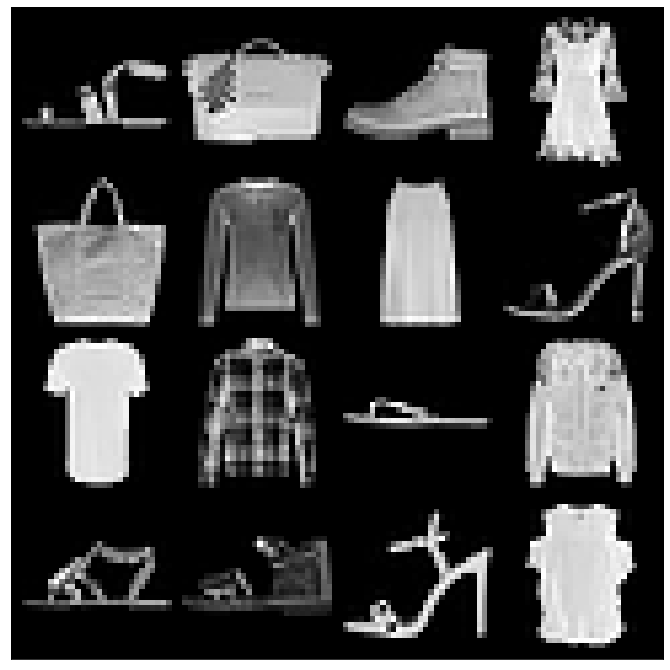

In [152]:
show_batch(train_dataloader)

In [6]:
import torch.nn.functional as F

In [7]:
kernel_size = 4
stride = 1
padding = 0
init_kernel = 16

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=1, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_kernel, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_kernel*2, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_kernel*4, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc5 = nn.Conv2d(
            in_channels=init_kernel*8, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )

        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_kernel*8, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_kernel*4, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_kernel*2, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec5 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=1, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = self.enc5(x)

        # get `mu` and `log_var`
        mu = x
        log_var = x

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        reconstruction = torch.sigmoid(self.dec5(x))
        return reconstruction, mu, log_var

In [8]:
vae = VAE()
optimizer = torch.optim.Adam(params=vae.parameters(), lr=0.0001, weight_decay=1e-5)
def vae_loss(recon_x,x,mu,log_var):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1,1,28,28), x.view(-1, 1,28,28), reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_loss

In [274]:
def fit(model, dataloader,epochs):
    model.train()
    running_loss = 0.0
    for epoch in range(0,epochs): 
        print(f"Epoch {epoch+1}")
        for i, (data,_) in enumerate(dataloader): 
            optimizer.zero_grad()
            reconstruction, mu, logvar = model(data)
            loss = vae_loss(reconstruction,data, mu, logvar)
            loss.backward()
            running_loss += loss.item()
            optimizer.step()
        train_loss = running_loss/len(dataloader.dataset)
        print(f"Train Loss: {train_loss:.4f}")
    return train_loss

In [276]:
fit(vae,train_dataloader,10)

KeyboardInterrupt: 

In [ ]:
res = vae.forward(train_data[0][0].view((1,1,28,28)))

In [ ]:
plt.imshow(res[0][0].permute(1, 2, 0).detach().numpy())

In [311]:
from torchvision.utils import save_image

def save_fake_images(sample_vectors,model):
    fake_images = model(sample_vectors)[0]
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(fake_images, os.path.join('./', fake_fname), nrow=4)

In [312]:
def show_res_batch(images):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images[:16], nrow=4).permute(1, 2, 0).clamp(0,1).detach().numpy())

In [313]:
r_input = torch.randn([16,1,28,28])

In [314]:
res_noise = vae.forward(r_input)

NameError: name 'index' is not defined

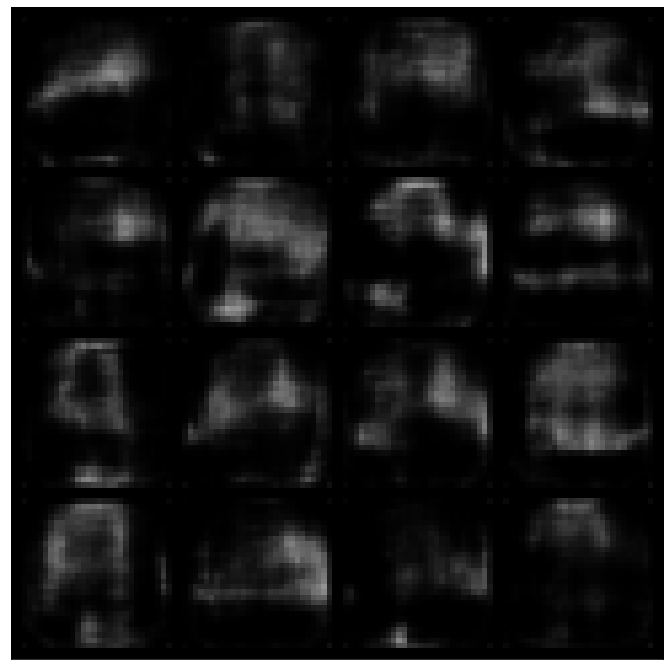

In [315]:
show_res_batch(res_noise[0])
save_fake_images(res_noise[0],vae)